In [1]:
import torch
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output
import numpy as np
import pylab as pl
import wandb

from src import *

In [2]:
config = {
    'image':'adversarial_images/lizard_red.png',
    'growing_file':'Pretrained_models/lizard/lizard_persist.pt',
    'virus_file':'Pretrained_models/lizard/lizard_persist.pt',

    'target_size':40,
    'target_padding':8,
    'n_channels':15,
    'original_channel':-2,
    'virus_channel':-1,

    'pool_size': 512,
    'generator_iters_min':64,
    'generator_iters_max':96,
    'virus_rate':0.8,

    'start_appling_loss':64,
    'perturbation_multiplier':1e-3,

    'lr':1e-3,
    'batch_size':5,
    'n_epochs':40,
    'n_max_loss_ratio':8,
    'evolution_iters':96,
    'kind':'persist',
    'skip_update':1,
    'skip_damage':1,
    'reset_prob':0,

    'step_size':20,
    'gamma':0.3,

    'trained_model_name': 'lizard_green_to_red'
    }

config["n_max_losses"] = max(1, config["batch_size"] // config["n_max_loss_ratio"])
config["image_size"] = config["target_size"] + config["target_padding"]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the growing CA part
old_CA = NeuralCA(device=device)
old_CA.load(config["growing_file"])

for param in old_CA.parameters():
   param.requires_grad = False

Successfully loaded model!


512 cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


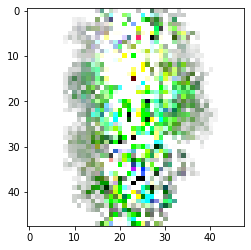

In [7]:
# Starting state
class Generator:
    def __init__(self, n_channels, image_size, CA, iter_func=ExponentialSampler(min=40, max=64)):
        self.n_channels = n_channels
        self.image_size = image_size
        self.CA = CA
        self.iter_func = iter_func

    def __call__(self, n_images, device):
        images = make_seed(n_images, self.n_channels, self.image_size, n_CAs=1, alpha_channel=3, device=device)
        print(n_images, device)
        batch_size = 32
        for i in range(0, n_images, batch_size):
            images[i:i+batch_size] = self.CA.evolve(images[i:i+batch_size], self.iter_func()[0])

        return images.to(device)

generator = Generator(config["n_channels"], config["image_size"], old_CA)
pool = SamplePool(config["pool_size"], generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 cpu


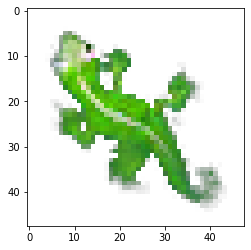

In [20]:
imshow(generator(1, "cpu")[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


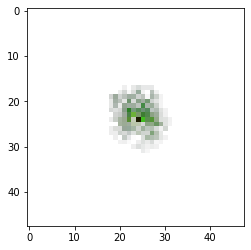

In [46]:
imshow(pool.sample(1)[0][0])

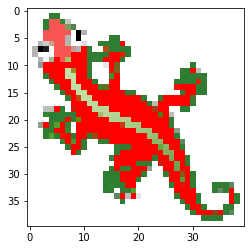

In [32]:
# Imports the target emoji
target = read_image("images/" + config["image"], ImageReadMode.RGB_ALPHA).float()
target = T.Resize((config["target_size"], config["target_size"]))(target)
target = RGBAtoFloat(target)

imshow(target)

In [33]:
# Send target to device
target = target.to(device)

In [34]:
# Load the virus CA part
new_CA = NeuralCA(device=device)
new_CA.load(config["virus_file"])
model = VirusCA(old_CA, new_CA, mutation_probability=config["virus_rate"])
model.initialized = False

Successfully loaded model!


In [35]:
wandb.init(mode="disabled")

In [ ]:
losses = [NCALoss(pad(target, config["target_padding"]), alpha_channels=[3])]
weights = [ConstantWeight(config["start_appling_loss"])]

criterion = CombinedLoss(losses, weights)

model.end_step_loss = NCADistance(old_CA, new_CA, config["perturbation_multiplier"])

In [ ]:
# Train the model
# wandb.watch(model, log_freq=64)

params = model.CAs[1].parameters()

optimizer = torch.optim.Adam(params, lr=config["lr"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config["step_size"], config["gamma"])

model.train_CA(optimizer, criterion, pool, scheduler=scheduler, **config)

In [ ]:
# Show losses
model.plot_losses()

In [ ]:
# Show a sample from the pool images
imshow(pool.sample(1)[0][0])

In [13]:
# Save the model and upload it to wandb
model.new_CA.save(f"Pretrained_models/mask/mask {mask_percentage*100}% persist.pt")

wandb.log({"state_dict": model.new_CA.state_dict()})
wandb.save(f"Pretrained_models/mask/mask {mask_percentage*100}% persist.pt")

Successfully saved model!


['/home/lettera/Desktop/neural_cellular_automata/pytorch_ca/wandb/run-20211026_171534-30ewk9yt/files/Pretrained_models/mask/mask 95.0% persist.pt']

In [ ]:
# Upload pool images to wandb
imgs = []

for i in range(12):
    img = np.asarray(pool.sample(1)[0][0].cpu().permute(1, 2, 0)[:, :, :4])
    img = wandb.Image(img)
    imgs.append(img)

wandb.log({"pool samples": imgs})

In [ ]:
# Show the virus cell mask
pl.matshow(model.new_cells.cpu()[0,0])

In [ ]:
# Upload mask to wandb
wandb.log({"mask": wandb.Image(model.new_cells.cpu()[0,0])})

In [21]:
# Make a switch video
_ , _ = switch_video(old_CA, model, fname="mask 70%.mp4")

In [ ]:
# Upload the evolution video to wandb
wandb.log({"video": wandb.Video("prova.mp4", "video", fps=10, format="mp4")})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


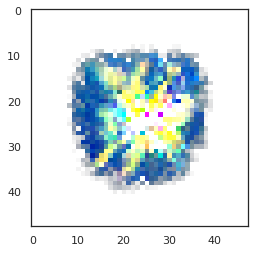

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


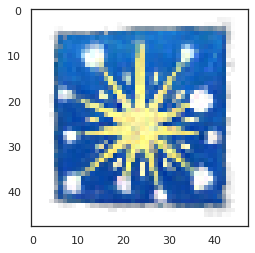

In [92]:
# Evolve the CA for 200 iters and plot it
x, _ = pool.sample(1)
imshow(x[0])
x = x.to(device)
model.update_cell_mask(x)

with torch.no_grad():
    x = model.evolve(x, 30)

imshow(x[0].cpu())

In [ ]:
def plot_test(results: dict, fname=None):

    fig, ax = plt.subplots()

    ax.loglog(results[0.], label="Growing", color="orange")

    for k, v in sorted(results.items()):
        if k < 0.6: continue
        colormap = pl.cm.get_cmap("viridis")
        ax.loglog(v, label=f"{k*100:.0f}%", color=colormap(2.2*(1-k)))

    pl.xlabel("Iterations")
    pl.ylabel("Loss")
    pl.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if fname is not None:
        pl.savefig(fname, dpi=300)
    pl.show()